In [8]:

import os
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO  # Ensure you have `pip install ultralytics`
import random


# --- CONFIG ---
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}") 
BASE_DATA_ROOT = "../soccernet_data/tracking"
GT_FILENAME = "gt.txt"
IMAGE_FOLDER = "img1"
IMAGE_EXTS = ['.jpg', '.png']
NUM_VISUALS = 10
SCORE_THRESH = 0.8
IOU_THRESH = 0.5
SAMPLE_PER_SEQ = 30

Using device: mps


Using device: mps
Processing sequences...


Sequences:   0%|          | 0/106 [00:00<?, ?it/s]


0: 384x640 12 persons, 45.3ms
Speed: 2.1ms preprocess, 45.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 44.5ms
Speed: 2.2ms preprocess, 44.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 1 sports ball, 41.4ms
Speed: 1.5ms preprocess, 41.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.5ms
Speed: 1.3ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 35.5ms
Speed: 1.6ms preprocess, 35.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.5ms
Speed: 1.7ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.4ms
Speed: 1.7ms preprocess, 36.4ms inference, 0.9ms postproce

Sequences:   1%|          | 1/106 [00:05<09:03,  5.18s/it]


0: 384x640 20 persons, 39.6ms
Speed: 1.7ms preprocess, 39.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 37.0ms
Speed: 1.5ms preprocess, 37.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 36.6ms
Speed: 1.5ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 135.0ms
Speed: 1.5ms preprocess, 135.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.5ms
Speed: 1.9ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.0ms
Speed: 1.4ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.8ms
Speed: 1.6ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.0ms
Speed: 1.7ms preprocess, 36.0ms inference, 0.7ms postprocess per image a

Sequences:   2%|▏         | 2/106 [00:09<08:20,  4.81s/it]


0: 384x640 16 persons, 40.8ms
Speed: 1.4ms preprocess, 40.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 38.6ms
Speed: 1.6ms preprocess, 38.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 37.2ms
Speed: 1.9ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.1ms
Speed: 1.6ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.5ms
Speed: 1.4ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 39.7ms
Speed: 1.5ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.4ms
Speed: 1.5ms preprocess, 38.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.0ms
Speed: 1.3ms preprocess, 39.0ms inference, 0.9ms postprocess per image at

Sequences:   3%|▎         | 3/106 [00:14<08:36,  5.01s/it]


0: 384x640 8 persons, 41.2ms
Speed: 1.6ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 36.5ms
Speed: 1.7ms preprocess, 36.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.1ms
Speed: 1.8ms preprocess, 36.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.6ms
Speed: 1.4ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 37.9ms
Speed: 1.3ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.9ms
Speed: 1.6ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 36.7ms
Speed: 1.9ms preprocess, 36.7ms inference, 0.7ms postprocess per image at 

Sequences:   4%|▍         | 4/106 [00:19<08:24,  4.95s/it]


0: 384x640 8 persons, 39.5ms
Speed: 1.9ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 56.3ms
Speed: 1.3ms preprocess, 56.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 37.9ms
Speed: 1.3ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.2ms
Speed: 1.2ms preprocess, 40.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.1ms
Speed: 1.6ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.7ms
Speed: 2.2ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.0ms
Speed: 1.4ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.5ms
Speed: 1.5ms preprocess, 36.5ms inference, 0.8ms postprocess per image at 

Sequences:   5%|▍         | 5/106 [00:25<08:47,  5.22s/it]


0: 384x640 7 persons, 120.3ms
Speed: 1.7ms preprocess, 120.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 35.1ms
Speed: 1.4ms preprocess, 35.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.6ms
Speed: 1.4ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 33.8ms
Speed: 1.5ms preprocess, 33.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.6ms
Speed: 1.8ms preprocess, 36.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 37.0ms
Speed: 1.8ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 37.5ms
Speed: 1.5ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.6ms
Speed: 2.4ms preprocess, 36.6ms inference, 0.8ms postprocess per image at

Sequences:   6%|▌         | 6/106 [00:30<08:41,  5.21s/it]


0: 384x640 12 persons, 40.2ms
Speed: 2.2ms preprocess, 40.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 39.4ms
Speed: 1.3ms preprocess, 39.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.6ms
Speed: 1.4ms preprocess, 38.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 36.7ms
Speed: 1.5ms preprocess, 36.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 35.3ms
Speed: 2.7ms preprocess, 35.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 36.6ms
Speed: 1.4ms preprocess, 36.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 36.2ms
Speed: 1.5ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 32.6ms
Speed: 1.5ms preprocess, 32.6ms inference, 0.7ms postprocess per image at

Sequences:   7%|▋         | 7/106 [00:36<09:00,  5.46s/it]


0: 384x640 16 persons, 41.0ms
Speed: 1.6ms preprocess, 41.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 44.5ms
Speed: 2.1ms preprocess, 44.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.0ms
Speed: 1.7ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.8ms
Speed: 1.7ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 39.8ms
Speed: 1.5ms preprocess, 39.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 41.6ms
Speed: 1.3ms preprocess, 41.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 40.7ms
Speed: 1.7ms preprocess, 40.7ms inference, 0.8ms postproce

Sequences:   8%|▊         | 8/106 [00:42<08:56,  5.48s/it]


0: 384x640 15 persons, 1 sports ball, 43.0ms
Speed: 1.8ms preprocess, 43.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 39.3ms
Speed: 2.0ms preprocess, 39.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.3ms
Speed: 1.9ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 42.4ms
Speed: 1.4ms preprocess, 42.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 38.8ms
Speed: 2.1ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.5ms
Speed: 1.8ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.8ms
Speed: 1.4ms preprocess, 37.8ms inference, 

Sequences:   8%|▊         | 9/106 [00:47<08:47,  5.44s/it]


0: 384x640 14 persons, 41.0ms
Speed: 1.4ms preprocess, 41.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 40.2ms
Speed: 1.6ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 39.2ms
Speed: 1.4ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 37.0ms
Speed: 1.3ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.8ms
Speed: 1.6ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.9ms
Speed: 1.5ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.3ms
Speed: 1.3ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 35.3ms
Speed: 2.0ms preprocess, 35.3ms inference, 0.7ms postprocess per image at

Sequences:   9%|▉         | 10/106 [00:52<08:34,  5.36s/it]


0: 384x640 18 persons, 40.9ms
Speed: 1.6ms preprocess, 40.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.3ms
Speed: 1.5ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.0ms
Speed: 1.2ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.7ms
Speed: 1.5ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.6ms
Speed: 1.5ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 39.8ms
Speed: 1.2ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 39.2ms
Speed: 1.3ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 1 sports ball, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.8ms postproce

Sequences:  10%|█         | 11/106 [00:57<08:12,  5.19s/it]


0: 384x640 12 persons, 44.5ms
Speed: 1.6ms preprocess, 44.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 42.7ms
Speed: 2.0ms preprocess, 42.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.1ms
Speed: 1.5ms preprocess, 41.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.4ms
Speed: 1.5ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 42.1ms
Speed: 1.9ms preprocess, 42.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.8ms
Speed: 1.6ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 41.3ms
Speed: 1.5ms preprocess, 41.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.8ms
Speed: 1.3ms preprocess, 38.8ms inference, 0.8ms postprocess per image at

Sequences:  11%|█▏        | 12/106 [01:03<08:22,  5.35s/it]


0: 384x640 14 persons, 43.5ms
Speed: 2.2ms preprocess, 43.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.9ms
Speed: 1.4ms preprocess, 40.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 38.7ms
Speed: 1.4ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 37.5ms
Speed: 1.4ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 39.3ms
Speed: 1.6ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.5ms
Speed: 1.4ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.9ms
Speed: 1.2ms preprocess, 38.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.2ms
Speed: 1.3ms preprocess, 39.2ms inference, 0.8ms postprocess per image at

Sequences:  12%|█▏        | 13/106 [01:08<08:14,  5.31s/it]


0: 384x640 16 persons, 41.5ms
Speed: 1.5ms preprocess, 41.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.2ms
Speed: 1.3ms preprocess, 37.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.8ms
Speed: 1.7ms preprocess, 41.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 clock, 38.0ms
Speed: 1.7ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.0ms
Speed: 1.4ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.6ms
Speed: 1.1ms preprocess, 38.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.6ms
Speed: 1.3ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 38.6ms
Speed: 1.4ms preprocess, 38.6ms inference, 0.8ms 

Sequences:  13%|█▎        | 14/106 [01:13<08:10,  5.33s/it]


0: 384x640 21 persons, 41.4ms
Speed: 1.7ms preprocess, 41.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 40.5ms
Speed: 1.2ms preprocess, 40.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 41.2ms
Speed: 1.5ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 41.6ms
Speed: 1.8ms preprocess, 41.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 39.8ms
Speed: 1.2ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 38.3ms
Speed: 1.3ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 48.2ms
Speed: 1.3ms preprocess, 48.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.6ms
Speed: 1.5ms preprocess, 41.6ms inference, 0.8ms postprocess per image at

Sequences:  14%|█▍        | 15/106 [01:19<08:19,  5.49s/it]


0: 384x640 12 persons, 43.5ms
Speed: 1.5ms preprocess, 43.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 185.0ms
Speed: 1.7ms preprocess, 185.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.4ms
Speed: 1.4ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 41.1ms
Speed: 1.8ms preprocess, 41.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.9ms
Speed: 1.5ms preprocess, 40.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 39.8ms
Speed: 1.6ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 38.6ms
Speed: 1.5ms preprocess, 38.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 41.9ms
Speed: 1.3ms preprocess, 41.9ms inference, 0.8ms postprocess per image a

Sequences:  15%|█▌        | 16/106 [01:25<08:17,  5.53s/it]


0: 384x640 19 persons, 45.4ms
Speed: 1.4ms preprocess, 45.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 40.4ms
Speed: 1.7ms preprocess, 40.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 39.6ms
Speed: 2.4ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 46.3ms
Speed: 1.7ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 40.8ms
Speed: 1.4ms preprocess, 40.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 38.8ms
Speed: 1.6ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 44.3ms
Speed: 1.6ms preprocess, 44.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 39.6ms
Speed: 1.6ms preprocess, 39.6ms inference, 0.7ms postprocess per image at

Sequences:  16%|█▌        | 17/106 [01:32<08:49,  5.95s/it]


0: 384x640 13 persons, 43.1ms
Speed: 1.5ms preprocess, 43.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 62.3ms
Speed: 3.6ms preprocess, 62.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 40.9ms
Speed: 1.4ms preprocess, 40.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 39.5ms
Speed: 1.6ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.4ms
Speed: 1.7ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 41.4ms
Speed: 1.6ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 39.3ms
Speed: 2.0ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.6ms
Speed: 1.6ms preprocess, 39.6ms inference, 0.8ms postprocess per image at

Sequences:  17%|█▋        | 18/106 [01:37<08:36,  5.87s/it]


0: 384x640 14 persons, 44.8ms
Speed: 1.5ms preprocess, 44.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.6ms
Speed: 1.8ms preprocess, 40.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 40.3ms
Speed: 1.4ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.4ms
Speed: 1.4ms preprocess, 40.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 42.0ms
Speed: 1.4ms preprocess, 42.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.9ms
Speed: 1.6ms preprocess, 37.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 41.2ms
Speed: 1.3ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 38.9ms
Speed: 1.6ms preprocess, 38.9ms inference, 0.8ms postprocess per image at sh

Sequences:  18%|█▊        | 19/106 [01:43<08:12,  5.66s/it]


0: 384x640 10 persons, 44.9ms
Speed: 1.4ms preprocess, 44.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 44.0ms
Speed: 2.0ms preprocess, 44.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.2ms
Speed: 1.6ms preprocess, 40.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 41.5ms
Speed: 1.4ms preprocess, 41.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 39.6ms
Speed: 1.7ms preprocess, 39.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 41.0ms
Speed: 1.4ms preprocess, 41.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 41.0ms
Speed: 1.5ms preprocess, 41.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.3ms
Speed: 1.4ms preprocess, 38.3ms inference, 0.7ms postprocess per image at 

Sequences:  19%|█▉        | 20/106 [01:47<07:33,  5.27s/it]


0: 384x640 12 persons, 190.7ms
Speed: 1.5ms preprocess, 190.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 40.7ms
Speed: 1.3ms preprocess, 40.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 41.0ms
Speed: 1.5ms preprocess, 41.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.8ms
Speed: 1.5ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 40.4ms
Speed: 1.3ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 40.2ms
Speed: 1.7ms preprocess, 40.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.0ms
Speed: 1.6ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 40.6ms
Speed: 1.3ms preprocess, 40.6ms inference, 0.8ms postproce

Sequences:  20%|█▉        | 21/106 [01:52<07:08,  5.04s/it]


0: 384x640 13 persons, 40.3ms
Speed: 1.4ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.3ms
Speed: 1.9ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.3ms
Speed: 1.9ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.8ms
Speed: 1.7ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.7ms
Speed: 1.5ms preprocess, 40.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.1ms
Speed: 1.2ms preprocess, 41.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 39.1ms
Speed: 1.3ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.7ms
Speed: 1.3ms preprocess, 38.7ms inference, 0.7ms postprocess per image at

Sequences:  21%|██        | 22/106 [01:57<07:08,  5.10s/it]


0: 384x640 16 persons, 43.6ms
Speed: 1.3ms preprocess, 43.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.3ms
Speed: 1.3ms preprocess, 41.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 39.5ms
Speed: 1.8ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.7ms
Speed: 1.3ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.8ms
Speed: 1.3ms preprocess, 40.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 41.3ms
Speed: 1.6ms preprocess, 41.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.1ms
Speed: 1.2ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 38.3ms
Speed: 1.4ms preprocess, 38.3ms inference, 0.8ms postprocess per image at s

Sequences:  22%|██▏       | 23/106 [02:01<06:41,  4.84s/it]


0: 384x640 14 persons, 43.1ms
Speed: 1.8ms preprocess, 43.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 39.1ms
Speed: 1.5ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.8ms
Speed: 1.2ms preprocess, 36.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.9ms
Speed: 1.9ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.4ms
Speed: 1.4ms preprocess, 39.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.3ms
Speed: 1.5ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 41.2ms
Speed: 1.3ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.5ms
Speed: 2.0ms preprocess, 40.5ms inference, 0.7ms postprocess per image at

Sequences:  23%|██▎       | 24/106 [02:06<06:46,  4.96s/it]


0: 384x640 17 persons, 39.1ms
Speed: 1.5ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.3ms
Speed: 1.3ms preprocess, 39.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.6ms
Speed: 1.3ms preprocess, 38.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.0ms
Speed: 1.4ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 42.7ms
Speed: 1.6ms preprocess, 42.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 1 sports ball, 39.2ms
Speed: 1.6ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 41.6ms
Speed: 1.8ms preprocess, 41.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.0ms
Speed: 1.6ms preprocess, 38.0ms inference, 0.8ms postproce

Sequences:  24%|██▎       | 25/106 [02:12<07:01,  5.20s/it]


0: 384x640 13 persons, 41.5ms
Speed: 1.3ms preprocess, 41.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 37.0ms
Speed: 1.6ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.5ms
Speed: 1.6ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 40.5ms
Speed: 1.3ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 38.8ms
Speed: 1.3ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.2ms
Speed: 1.3ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 36.4ms
Speed: 1.6ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 38.1ms
Speed: 1.4ms preprocess, 38.1ms inference, 0.9ms postprocess per image at s

Sequences:  25%|██▍       | 26/106 [02:17<07:02,  5.28s/it]


0: 384x640 13 persons, 174.3ms
Speed: 1.4ms preprocess, 174.3ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 40.3ms
Speed: 1.6ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.8ms
Speed: 1.4ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.6ms
Speed: 1.4ms preprocess, 39.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.8ms
Speed: 1.5ms preprocess, 38.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 41.1ms
Speed: 1.4ms preprocess, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 41.0ms
Speed: 1.5ms preprocess, 41.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 67.2ms
Speed: 1.8ms preprocess, 67.2ms inference, 0.7ms postpro

Sequences:  25%|██▌       | 27/106 [02:23<06:55,  5.26s/it]


0: 384x640 15 persons, 46.5ms
Speed: 1.5ms preprocess, 46.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 40.1ms
Speed: 1.8ms preprocess, 40.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 41.1ms
Speed: 1.3ms preprocess, 41.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 39.1ms
Speed: 1.6ms preprocess, 39.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.3ms
Speed: 1.6ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 36.7ms
Speed: 1.8ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 64.7ms
Speed: 1.7ms preprocess, 64.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 42.3ms
Speed: 1.6ms preprocess, 42.3ms inference, 0.7ms postprocess per image at sh

Sequences:  26%|██▋       | 28/106 [02:28<06:43,  5.17s/it]


0: 384x640 16 persons, 41.1ms
Speed: 1.3ms preprocess, 41.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 41.2ms
Speed: 2.2ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 39.1ms
Speed: 1.4ms preprocess, 39.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 37.5ms
Speed: 1.5ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 40.6ms
Speed: 1.8ms preprocess, 40.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.5ms
Speed: 1.4ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.3ms
Speed: 1.3ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 38.7ms
Speed: 3.4ms preprocess, 38.7ms inference, 0.8ms postprocess per image at sha

Sequences:  27%|██▋       | 29/106 [02:33<06:35,  5.14s/it]


0: 384x640 11 persons, 45.6ms
Speed: 1.4ms preprocess, 45.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.2ms
Speed: 1.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.5ms
Speed: 1.5ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 59.4ms
Speed: 102.4ms preprocess, 59.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 40.0ms
Speed: 1.5ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 38.0ms
Speed: 1.3ms preprocess, 38.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.6ms
Speed: 3.7ms preprocess, 38.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.1ms
Speed: 1.5ms preprocess, 38.1ms inference, 0.7ms postpro

Sequences:  28%|██▊       | 30/106 [02:37<06:20,  5.01s/it]


0: 384x640 8 persons, 76.8ms
Speed: 2.1ms preprocess, 76.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 41.2ms
Speed: 1.6ms preprocess, 41.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 40.9ms
Speed: 1.3ms preprocess, 40.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.6ms
Speed: 1.4ms preprocess, 39.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 61.9ms
Speed: 1.4ms preprocess, 61.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.2ms
Speed: 1.4ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.8ms
Speed: 2.0ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.3ms
Speed: 1.6ms preprocess, 40.3ms inference, 0.7ms postprocess per image at s

Sequences:  29%|██▉       | 31/106 [02:43<06:24,  5.13s/it]


0: 384x640 12 persons, 43.9ms
Speed: 1.6ms preprocess, 43.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 42.9ms
Speed: 1.8ms preprocess, 42.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 46.0ms
Speed: 3.4ms preprocess, 46.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 45.0ms
Speed: 1.9ms preprocess, 45.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 39.5ms
Speed: 1.7ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 37.3ms
Speed: 1.2ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 37.0ms
Speed: 1.2ms preprocess, 37.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.8ms
Speed: 1.1ms preprocess, 40.8ms inference, 0.8ms postprocess per image at s

Sequences:  30%|███       | 32/106 [02:48<06:29,  5.26s/it]


0: 384x640 9 persons, 43.6ms
Speed: 1.4ms preprocess, 43.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 39.6ms
Speed: 1.3ms preprocess, 39.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 34.5ms
Speed: 1.9ms preprocess, 34.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.8ms
Speed: 1.2ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 37.0ms
Speed: 1.3ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.0ms
Speed: 1.3ms preprocess, 36.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 37.1ms
Speed: 1.3ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 126.4ms
Speed: 2.9ms preprocess, 126.4ms inference,

Sequences:  31%|███       | 33/106 [02:53<06:13,  5.12s/it]


0: 384x640 17 persons, 1 sports ball, 45.4ms
Speed: 1.3ms preprocess, 45.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.9ms
Speed: 1.3ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 36.2ms
Speed: 1.3ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.9ms
Speed: 1.7ms preprocess, 39.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 38.5ms
Speed: 1.3ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.6ms
Speed: 1.3ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 45.2ms
Speed: 1.2ms preprocess, 45.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.0ms
Speed: 1.6ms preprocess, 38.0ms inference, 0.7ms postproce

Sequences:  32%|███▏      | 34/106 [02:58<06:03,  5.05s/it]


0: 384x640 24 persons, 44.5ms
Speed: 2.0ms preprocess, 44.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 1 sports ball, 41.8ms
Speed: 2.1ms preprocess, 41.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 45.4ms
Speed: 3.0ms preprocess, 45.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 36.8ms
Speed: 1.3ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 38.5ms
Speed: 1.6ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 36.6ms
Speed: 1.7ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 27 persons, 37.4ms
Speed: 1.4ms preprocess, 37.4ms inference, 0.9ms postproce

Sequences:  33%|███▎      | 35/106 [03:04<06:16,  5.31s/it]


0: 384x640 11 persons, 46.6ms
Speed: 1.7ms preprocess, 46.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 41.5ms
Speed: 2.3ms preprocess, 41.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.2ms
Speed: 1.4ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.1ms
Speed: 1.3ms preprocess, 36.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 37.4ms
Speed: 1.4ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 37.6ms
Speed: 1.3ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 38.0ms
Speed: 1.2ms preprocess, 38.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 53.8ms
Speed: 1.9ms preprocess, 53.8ms inference, 0.8ms postprocess per image at s

Sequences:  34%|███▍      | 36/106 [03:09<05:56,  5.09s/it]


0: 384x640 13 persons, 44.2ms
Speed: 1.4ms preprocess, 44.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 36.6ms
Speed: 1.4ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.5ms
Speed: 1.2ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.8ms
Speed: 1.3ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 36.8ms
Speed: 1.2ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.6ms
Speed: 1.1ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.4ms
Speed: 1.3ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.1ms
Speed: 1.5ms preprocess, 36.1ms inference, 0.8ms postprocess per image at

Sequences:  35%|███▍      | 37/106 [03:13<05:43,  4.97s/it]


0: 384x640 7 persons, 41.2ms
Speed: 1.4ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.6ms
Speed: 1.3ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.4ms
Speed: 1.7ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 36.4ms
Speed: 1.3ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 36.1ms
Speed: 1.4ms preprocess, 36.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 35.9ms
Speed: 1.3ms preprocess, 35.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.2ms
Speed: 1.3ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 37.5ms
Speed: 1.3ms preprocess, 37.5ms inference, 0.8ms postprocess

Sequences:  36%|███▌      | 38/106 [03:18<05:26,  4.79s/it]


0: 384x640 15 persons, 45.1ms
Speed: 1.9ms preprocess, 45.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 38.5ms
Speed: 1.4ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.4ms
Speed: 2.3ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.6ms
Speed: 1.5ms preprocess, 38.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.3ms
Speed: 1.2ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 36.9ms
Speed: 1.3ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 36.8ms
Speed: 1.5ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.7ms
Speed: 1.2ms preprocess, 39.7ms inference, 0.9ms postproce

Sequences:  37%|███▋      | 39/106 [03:23<05:35,  5.00s/it]


0: 384x640 14 persons, 41.6ms
Speed: 1.3ms preprocess, 41.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.5ms
Speed: 1.7ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.6ms
Speed: 1.5ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 61.4ms
Speed: 1.2ms preprocess, 61.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 38.0ms
Speed: 2.1ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 37.0ms
Speed: 1.3ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 35.2ms
Speed: 1.4ms preprocess, 35.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 36.5ms
Speed: 1.3ms preprocess, 36.5ms inference, 0.7ms postprocess per image at sh

Sequences:  38%|███▊      | 40/106 [03:27<05:15,  4.79s/it]


0: 384x640 15 persons, 42.1ms
Speed: 1.3ms preprocess, 42.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.7ms
Speed: 1.3ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 36.0ms
Speed: 1.3ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 36.1ms
Speed: 1.4ms preprocess, 36.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 36.0ms
Speed: 1.4ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 35.7ms
Speed: 1.8ms preprocess, 35.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.1ms
Speed: 1.2ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 37.4ms
Speed: 1.2ms preprocess, 37.4ms inference, 0.7ms postprocess 

Sequences:  39%|███▊      | 41/106 [03:32<05:12,  4.81s/it]


0: 384x640 17 persons, 41.0ms
Speed: 1.2ms preprocess, 41.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.5ms
Speed: 1.4ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 34.0ms
Speed: 1.3ms preprocess, 34.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 33.9ms
Speed: 1.6ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 32.6ms
Speed: 1.7ms preprocess, 32.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 31.3ms
Speed: 1.4ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 31.7ms
Speed: 1.5ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 31.6ms
Speed: 1.6ms preprocess, 31.6ms inference, 0.7ms postprocess

Sequences:  40%|███▉      | 42/106 [03:37<05:01,  4.71s/it]


0: 384x640 15 persons, 40.4ms
Speed: 1.4ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 36.4ms
Speed: 1.3ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 35.8ms
Speed: 1.5ms preprocess, 35.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 33.8ms
Speed: 1.5ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 34.9ms
Speed: 1.4ms preprocess, 34.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 33.3ms
Speed: 1.7ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 1 kite, 31.8ms
Speed: 1.7ms preprocess, 31.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 31.2ms
Speed: 1.5ms preprocess, 31.2ms inference, 0.7ms postprocess per 

Sequences:  41%|████      | 43/106 [03:41<04:56,  4.71s/it]


0: 384x640 11 persons, 42.6ms
Speed: 1.6ms preprocess, 42.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.0ms
Speed: 1.2ms preprocess, 36.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 32.7ms
Speed: 2.5ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 33.1ms
Speed: 1.4ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 32.4ms
Speed: 1.3ms preprocess, 32.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 31.8ms
Speed: 1.3ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 34.0ms
Speed: 1.2ms preprocess, 34.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 32.6ms
Speed: 1.7ms preprocess, 32.6ms inference, 0.7ms postprocess per image at s

Sequences:  42%|████▏     | 44/106 [03:46<04:50,  4.69s/it]


0: 384x640 11 persons, 46.9ms
Speed: 1.2ms preprocess, 46.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.7ms
Speed: 2.4ms preprocess, 40.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 34.8ms
Speed: 1.3ms preprocess, 34.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 36.4ms
Speed: 1.7ms preprocess, 36.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 35.9ms
Speed: 1.4ms preprocess, 35.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 36.2ms
Speed: 1.2ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 34.7ms
Speed: 1.4ms preprocess, 34.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 34.8ms
Speed: 1.2ms preprocess, 34.8ms inference, 0.8ms postprocess per image at 

Sequences:  42%|████▏     | 45/106 [03:50<04:38,  4.56s/it]


0: 384x640 9 persons, 38.4ms
Speed: 1.8ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 1 sports ball, 36.2ms
Speed: 1.2ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 33.9ms
Speed: 1.4ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.8ms
Speed: 1.2ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 37.2ms
Speed: 1.4ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 35.2ms
Speed: 1.9ms preprocess, 35.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.4ms
Speed: 1.3ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 37.6ms
Speed: 1.5ms preprocess, 37.6ms inference, 0.8ms postproces

Sequences:  43%|████▎     | 46/106 [03:55<04:35,  4.60s/it]


0: 384x640 10 persons, 120.2ms
Speed: 1.3ms preprocess, 120.2ms inference, 5.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 35.1ms
Speed: 1.9ms preprocess, 35.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 34.3ms
Speed: 1.3ms preprocess, 34.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 57.9ms
Speed: 1.4ms preprocess, 57.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 33.8ms
Speed: 1.8ms preprocess, 33.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 34.7ms
Speed: 1.3ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 35.7ms
Speed: 1.4ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 35.4ms
Speed: 1.5ms preprocess, 35.4ms inference, 0.7ms postprocess per image at

Sequences:  44%|████▍     | 47/106 [03:59<04:26,  4.53s/it]


0: 384x640 9 persons, 41.2ms
Speed: 1.6ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 35.8ms
Speed: 1.3ms preprocess, 35.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 36.1ms
Speed: 1.1ms preprocess, 36.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 34.8ms
Speed: 1.8ms preprocess, 34.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 34.5ms
Speed: 1.5ms preprocess, 34.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 32.9ms
Speed: 1.3ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 34.7ms
Speed: 1.6ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 34.3ms
Speed: 1.5ms preprocess, 34.3ms inference, 0.7ms postprocess per image at s

Sequences:  45%|████▌     | 48/106 [04:04<04:19,  4.47s/it]


0: 384x640 17 persons, 1 sports ball, 41.2ms
Speed: 1.8ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.7ms
Speed: 1.4ms preprocess, 36.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 37.0ms
Speed: 1.3ms preprocess, 37.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 34.6ms
Speed: 1.3ms preprocess, 34.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 1 sports ball, 33.8ms
Speed: 1.8ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 35.7ms
Speed: 1.5ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 35.5ms
Speed: 1.3ms preprocess, 35.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 sports ball, 37.7m

Sequences:  46%|████▌     | 49/106 [04:09<04:21,  4.59s/it]


0: 384x640 16 persons, 45.3ms
Speed: 1.2ms preprocess, 45.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 40.0ms
Speed: 2.2ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.8ms
Speed: 1.9ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.3ms
Speed: 2.3ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 34.5ms
Speed: 1.4ms preprocess, 34.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 35.4ms
Speed: 1.2ms preprocess, 35.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.8ms
Speed: 1.6ms preprocess, 37.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 39.7ms
Speed: 1.7ms preprocess, 39.7ms inference, 0.8ms postprocess per image at s

Sequences:  47%|████▋     | 50/106 [04:13<04:17,  4.60s/it]


0: 384x640 14 persons, 140.4ms
Speed: 1.6ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 166.3ms
Speed: 2.1ms preprocess, 166.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 42.6ms
Speed: 2.6ms preprocess, 42.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 44.5ms
Speed: 1.6ms preprocess, 44.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 42.6ms
Speed: 1.6ms preprocess, 42.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 2 sports balls, 38.5ms
Speed: 1.3ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 43.7ms
Speed: 1.3ms preprocess, 43.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 43.4ms
Speed: 2.1ms preprocess, 43.4ms inference, 0.8ms post

Sequences:  48%|████▊     | 51/106 [04:19<04:32,  4.95s/it]


0: 384x640 15 persons, 41.9ms
Speed: 1.4ms preprocess, 41.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.6ms
Speed: 1.2ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.3ms
Speed: 1.2ms preprocess, 36.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 36.2ms
Speed: 1.3ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.1ms
Speed: 1.2ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 60.3ms
Speed: 1.6ms preprocess, 60.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 36.1ms
Speed: 1.4ms preprocess, 36.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 39.6ms
Speed: 1.3ms preprocess, 39.6ms inference, 0.8ms postprocess 

Sequences:  49%|████▉     | 52/106 [04:24<04:24,  4.90s/it]


0: 384x640 22 persons, 1 sports ball, 42.0ms
Speed: 1.4ms preprocess, 42.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 39.8ms
Speed: 1.9ms preprocess, 39.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 39.5ms
Speed: 1.3ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 38.1ms
Speed: 1.5ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 36.4ms
Speed: 1.3ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 sports ball, 41.2ms
Speed: 1.6ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 43.3ms
Speed: 1.4ms preprocess, 43.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 34.7ms
Speed: 1.4ms preprocess, 34.7ms inference, 

Sequences:  50%|█████     | 53/106 [04:29<04:25,  5.00s/it]


0: 384x640 7 persons, 43.7ms
Speed: 1.6ms preprocess, 43.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.0ms
Speed: 1.2ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 35.8ms
Speed: 1.9ms preprocess, 35.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.5ms
Speed: 1.4ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.6ms
Speed: 1.5ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 60.7ms
Speed: 1.9ms preprocess, 60.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.6ms
Speed: 1.6ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 39.7ms
Speed: 1.6ms preprocess, 39.7ms inference, 0.7ms postprocess per image at 

Sequences:  51%|█████     | 54/106 [04:35<04:29,  5.18s/it]


0: 384x640 16 persons, 67.9ms
Speed: 2.4ms preprocess, 67.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 35.5ms
Speed: 1.2ms preprocess, 35.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 35.7ms
Speed: 1.8ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 36.7ms
Speed: 1.3ms preprocess, 36.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 36.4ms
Speed: 1.4ms preprocess, 36.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.5ms
Speed: 1.2ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.9ms
Speed: 1.3ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 38.8ms
Speed: 1.5ms preprocess, 38.8ms inference, 0.7ms postprocess per image at

Sequences:  52%|█████▏    | 55/106 [04:40<04:28,  5.26s/it]


0: 384x640 18 persons, 39.4ms
Speed: 1.7ms preprocess, 39.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 car, 1 frisbee, 40.0ms
Speed: 1.8ms preprocess, 40.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.0ms
Speed: 1.3ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.1ms
Speed: 1.2ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 42.2ms
Speed: 1.5ms preprocess, 42.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.4ms
Speed: 1.3ms preprocess, 39.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 59.9ms
Speed: 2.2ms preprocess, 59.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.4ms
Speed: 1.3ms preprocess, 38.4ms inference, 0.9ms postpr

Sequences:  53%|█████▎    | 56/106 [04:45<04:16,  5.13s/it]


0: 384x640 14 persons, 39.8ms
Speed: 1.4ms preprocess, 39.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 car, 37.6ms
Speed: 1.4ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 sports ball, 38.4ms
Speed: 2.2ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 35.8ms
Speed: 1.4ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.3ms
Speed: 1.4ms preprocess, 39.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.5ms
Speed: 2.0ms preprocess, 37.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.2ms
Speed: 1.4ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.3ms
Speed: 1.3ms preprocess, 36.3ms inference, 0.8ms po

Sequences:  54%|█████▍    | 57/106 [04:50<04:09,  5.09s/it]


0: 384x640 13 persons, 43.4ms
Speed: 1.4ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 40.8ms
Speed: 1.6ms preprocess, 40.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 41.5ms
Speed: 2.0ms preprocess, 41.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 41.1ms
Speed: 2.1ms preprocess, 41.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 39.0ms
Speed: 1.6ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 39.6ms
Speed: 1.6ms preprocess, 39.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 41.5ms
Speed: 1.4ms preprocess, 41.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 37.7ms
Speed: 1.7ms preprocess, 37.7ms inference, 0.8ms postprocess per image at s

Sequences:  55%|█████▍    | 58/106 [04:55<04:01,  5.04s/it]


0: 384x640 11 persons, 145.7ms
Speed: 1.6ms preprocess, 145.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 38.2ms
Speed: 1.3ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 41.9ms
Speed: 1.3ms preprocess, 41.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 74.1ms
Speed: 1.3ms preprocess, 74.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.0ms
Speed: 1.3ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 40.0ms
Speed: 1.9ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 38.3ms
Speed: 1.2ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 39.6ms
Speed: 1.4ms preprocess, 39.6ms inference, 0.9ms postproces

Sequences:  56%|█████▌    | 59/106 [04:59<03:50,  4.90s/it]


0: 384x640 14 persons, 64.2ms
Speed: 1.5ms preprocess, 64.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.2ms
Speed: 1.4ms preprocess, 38.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 39.9ms
Speed: 1.4ms preprocess, 39.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 37.7ms
Speed: 1.8ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 38.3ms
Speed: 1.3ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 41.5ms
Speed: 2.5ms preprocess, 41.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 39.4ms
Speed: 1.4ms preprocess, 39.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 42.1ms
Speed: 1.4ms preprocess, 42.1ms inference, 0.8ms postprocess per image at s

Sequences:  57%|█████▋    | 60/106 [05:04<03:46,  4.92s/it]


0: 384x640 11 persons, 45.3ms
Speed: 2.0ms preprocess, 45.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 82.7ms
Speed: 1.4ms preprocess, 82.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 40.5ms
Speed: 1.4ms preprocess, 40.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.7ms
Speed: 1.5ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 35.1ms
Speed: 1.3ms preprocess, 35.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 38.6ms
Speed: 1.8ms preprocess, 38.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 41.9ms
Speed: 1.7ms preprocess, 41.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 39.8ms
Speed: 2.1ms preprocess, 39.8ms inference, 0.7ms postprocess per image at sha

Sequences:  58%|█████▊    | 61/106 [05:08<03:28,  4.63s/it]


0: 384x640 16 persons, 39.0ms
Speed: 1.3ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 34.8ms
Speed: 1.4ms preprocess, 34.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.7ms
Speed: 1.7ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 2 sports balls, 37.7ms
Speed: 1.2ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.1ms
Speed: 1.4ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.8ms
Speed: 1.3ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.7ms
Speed: 1.5ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.9ms
Speed: 1.6ms preprocess, 37.9ms inference, 0.7ms postproc

Sequences:  58%|█████▊    | 62/106 [05:13<03:30,  4.79s/it]


0: 384x640 13 persons, 41.1ms
Speed: 1.5ms preprocess, 41.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.3ms
Speed: 1.4ms preprocess, 39.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.9ms
Speed: 1.5ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 35.0ms
Speed: 1.3ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.1ms
Speed: 1.5ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 40.2ms
Speed: 1.3ms preprocess, 40.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 138.8ms
Speed: 6.5ms preprocess, 138.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 40.8ms
Speed: 1.8ms preprocess, 40.8ms inference

Sequences:  59%|█████▉    | 63/106 [05:18<03:27,  4.82s/it]


0: 384x640 9 persons, 47.0ms
Speed: 4.0ms preprocess, 47.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.5ms
Speed: 1.6ms preprocess, 38.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.0ms
Speed: 1.3ms preprocess, 37.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 35.4ms
Speed: 1.1ms preprocess, 35.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 55.5ms
Speed: 1.4ms preprocess, 55.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 35.2ms
Speed: 1.3ms preprocess, 35.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.8ms
Speed: 1.2ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 35.1ms
Speed: 1.2ms preprocess, 35.1ms inference, 0.8ms postprocess per image at 

Sequences:  60%|██████    | 64/106 [05:23<03:22,  4.82s/it]


0: 384x640 17 persons, 50.6ms
Speed: 1.7ms preprocess, 50.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 43.7ms
Speed: 1.8ms preprocess, 43.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.8ms
Speed: 1.7ms preprocess, 39.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.1ms
Speed: 1.2ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 33.8ms
Speed: 1.4ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 34.9ms
Speed: 1.5ms preprocess, 34.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 31.5ms
Speed: 1.5ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 32.4ms
Speed: 1.4ms preprocess, 32.4ms inference, 0.7ms postprocess per image at

Sequences:  61%|██████▏   | 65/106 [05:28<03:16,  4.80s/it]


0: 384x640 13 persons, 39.4ms
Speed: 1.9ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 43.9ms
Speed: 1.4ms preprocess, 43.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.1ms
Speed: 2.2ms preprocess, 41.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.9ms
Speed: 1.2ms preprocess, 39.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 36.5ms
Speed: 1.8ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 44.0ms
Speed: 1.4ms preprocess, 44.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 42.6ms
Speed: 1.4ms preprocess, 42.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.4ms
Speed: 1.3ms preprocess, 39.4ms inference, 0.

Sequences:  62%|██████▏   | 66/106 [05:32<03:05,  4.63s/it]


0: 384x640 9 persons, 60.1ms
Speed: 2.1ms preprocess, 60.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 106.3ms
Speed: 1.5ms preprocess, 106.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 41.8ms
Speed: 2.0ms preprocess, 41.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 39.9ms
Speed: 1.5ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 42.3ms
Speed: 5.6ms preprocess, 42.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 40.4ms
Speed: 1.5ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 133.9ms
Speed: 22.9ms preprocess, 133.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 36.4ms
Speed: 1.3ms preprocess, 36.

Sequences:  63%|██████▎   | 67/106 [05:37<03:02,  4.68s/it]


0: 384x640 8 persons, 1 sports ball, 43.8ms
Speed: 2.0ms preprocess, 43.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 41.0ms
Speed: 1.5ms preprocess, 41.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 41.4ms
Speed: 1.8ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 41.4ms
Speed: 1.7ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 41.5ms
Speed: 1.3ms preprocess, 41.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.1ms
Speed: 1.4ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.7ms
Speed: 2.4ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 39.5ms
Speed: 1.4ms preprocess, 39.5ms inference, 0.8ms postprocess p

Sequences:  64%|██████▍   | 68/106 [05:42<02:58,  4.71s/it]


0: 384x640 19 persons, 38.3ms
Speed: 1.2ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 35.9ms
Speed: 2.0ms preprocess, 35.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 35.8ms
Speed: 1.7ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 37.3ms
Speed: 1.5ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.8ms
Speed: 1.4ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 37.5ms
Speed: 1.3ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 38.9ms
Speed: 1.3ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 39.3ms
Speed: 1.7ms preprocess, 39.3ms inference, 0.7ms postprocess per image at

Sequences:  65%|██████▌   | 69/106 [05:48<03:08,  5.10s/it]


0: 384x640 18 persons, 42.9ms
Speed: 1.2ms preprocess, 42.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.5ms
Speed: 1.4ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 1 sports ball, 37.8ms
Speed: 1.4ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.4ms
Speed: 1.3ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 1 sports ball, 40.7ms
Speed: 10.2ms preprocess, 40.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 39.1ms
Speed: 1.3ms preprocess, 39.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 36.4ms
Speed: 1.4ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 37.6ms
Speed: 1.9ms preprocess, 37.6ms inference, 

Sequences:  66%|██████▌   | 70/106 [05:53<03:06,  5.18s/it]


0: 384x640 9 persons, 41.0ms
Speed: 1.1ms preprocess, 41.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 56.9ms
Speed: 1.4ms preprocess, 56.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 35.4ms
Speed: 1.3ms preprocess, 35.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.7ms
Speed: 1.3ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.6ms
Speed: 2.0ms preprocess, 37.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.3ms
Speed: 1.2ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.9ms
Speed: 1.3ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.7ms
Speed: 2.0ms preprocess, 36.7ms inference, 0.8ms postprocess per image at 

Sequences:  67%|██████▋   | 71/106 [05:58<02:56,  5.04s/it]


0: 384x640 10 persons, 37.6ms
Speed: 1.3ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 35.6ms
Speed: 1.9ms preprocess, 35.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.7ms
Speed: 1.2ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 37.7ms
Speed: 1.9ms preprocess, 37.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 40.5ms
Speed: 1.8ms preprocess, 40.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 59.9ms
Speed: 1.8ms preprocess, 59.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.0ms
Speed: 1.5ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.9ms
Speed: 2.1ms preprocess, 37.9ms inference, 0.8ms postprocess per image at

Sequences:  68%|██████▊   | 72/106 [06:03<02:49,  4.99s/it]


0: 384x640 12 persons, 1 sports ball, 62.1ms
Speed: 1.3ms preprocess, 62.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 37.5ms
Speed: 1.8ms preprocess, 37.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 38.2ms
Speed: 1.3ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.7ms
Speed: 1.2ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.8ms
Speed: 1.4ms preprocess, 36.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 37.4ms
Speed: 2.1ms preprocess, 37.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.0ms
Speed: 1.3ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 46.5ms
Speed: 1.7ms preprocess, 46.5ms inference, 

Sequences:  69%|██████▉   | 73/106 [06:08<02:46,  5.04s/it]


0: 384x640 14 persons, 40.0ms
Speed: 1.7ms preprocess, 40.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 52.8ms
Speed: 2.3ms preprocess, 52.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.7ms
Speed: 1.4ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.7ms
Speed: 1.6ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.7ms
Speed: 1.3ms preprocess, 37.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 36.3ms
Speed: 1.4ms preprocess, 36.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 34.7ms
Speed: 1.5ms preprocess, 34.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 36.5ms
Speed: 1.8ms preprocess, 36.5ms inference, 0.7ms postproce

Sequences:  70%|██████▉   | 74/106 [06:12<02:37,  4.92s/it]


0: 384x640 4 persons, 87.3ms
Speed: 1.6ms preprocess, 87.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.2ms
Speed: 5.1ms preprocess, 40.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.1ms
Speed: 1.5ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 38.1ms
Speed: 1.4ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.6ms
Speed: 1.8ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 58.3ms
Speed: 1.2ms preprocess, 58.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 42.7ms
Speed: 1.4ms preprocess, 42.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.3ms
Speed: 1.3ms preprocess, 40.3ms inference, 0.8ms postprocess per image at 

Sequences:  71%|███████   | 75/106 [06:17<02:32,  4.93s/it]


0: 384x640 6 persons, 1 sports ball, 67.8ms
Speed: 1.3ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.6ms
Speed: 1.3ms preprocess, 37.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 39.1ms
Speed: 1.6ms preprocess, 39.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 36.6ms
Speed: 1.3ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 sports ball, 37.1ms
Speed: 1.7ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 38.0ms
Speed: 1.3ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 35.9ms
Speed: 1.4ms prepr

Sequences:  72%|███████▏  | 76/106 [06:22<02:21,  4.72s/it]


0: 384x640 11 persons, 41.6ms
Speed: 1.3ms preprocess, 41.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 35.5ms
Speed: 1.2ms preprocess, 35.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.5ms
Speed: 1.3ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.0ms
Speed: 1.3ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 37.9ms
Speed: 1.3ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 37.6ms
Speed: 1.2ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.0ms
Speed: 1.2ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 58.7ms
Speed: 1.2ms preprocess, 58.7ms inference, 0.8ms postprocess per image at s

Sequences:  73%|███████▎  | 77/106 [06:26<02:17,  4.75s/it]


0: 384x640 9 persons, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 36.9ms
Speed: 1.5ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 38.0ms
Speed: 1.2ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 41.9ms
Speed: 1.2ms preprocess, 41.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.0ms
Speed: 1.4ms preprocess, 38.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 39.9ms
Speed: 1.4ms preprocess, 39.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 40.5ms
Speed: 1.2ms preprocess, 40.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 37.9ms
Speed: 1.4ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape 

Sequences:  74%|███████▎  | 78/106 [06:31<02:07,  4.56s/it]


0: 384x640 14 persons, 1 sports ball, 40.5ms
Speed: 1.5ms preprocess, 40.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.4ms
Speed: 1.6ms preprocess, 36.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 2 sports balls, 35.6ms
Speed: 1.3ms preprocess, 35.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.4ms
Speed: 1.4ms preprocess, 37.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.7ms
Speed: 1.3ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.5ms
Speed: 1.3ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 72.7ms
Speed: 1.4ms preprocess, 72.7ms inference, 33.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 1 sports ball, 81.2ms
Speed: 1.9m

Sequences:  75%|███████▍  | 79/106 [06:35<02:03,  4.56s/it]


0: 384x640 11 persons, 134.4ms
Speed: 1.5ms preprocess, 134.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.2ms
Speed: 2.0ms preprocess, 36.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 58.0ms
Speed: 1.7ms preprocess, 58.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.3ms
Speed: 1.6ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.6ms
Speed: 1.5ms preprocess, 38.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 39.4ms
Speed: 1.3ms preprocess, 39.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 40.0ms
Speed: 1.2ms preprocess, 40.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 37.5ms
Speed: 1.2ms preprocess, 37.5ms inference, 0.9ms postprocess per image 

Sequences:  75%|███████▌  | 80/106 [06:40<02:03,  4.73s/it]


0: 384x640 9 persons, 1 sports ball, 40.0ms
Speed: 1.8ms preprocess, 40.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.1ms
Speed: 1.1ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 40.0ms
Speed: 1.4ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.5ms
Speed: 1.3ms preprocess, 39.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 37.6ms
Speed: 1.5ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 sports balls, 38.7ms
Speed: 1.5ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 37.3ms
Speed: 1.4ms preprocess, 37.3m

Sequences:  76%|███████▋  | 81/106 [06:45<01:56,  4.65s/it]


0: 384x640 14 persons, 42.4ms
Speed: 1.8ms preprocess, 42.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 39.5ms
Speed: 1.7ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.1ms
Speed: 1.5ms preprocess, 38.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.9ms
Speed: 1.5ms preprocess, 37.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.5ms
Speed: 1.4ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.8ms
Speed: 1.9ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.1ms
Speed: 1.6ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.0ms
Speed: 1.5ms preprocess, 37.0ms inference, 0.7ms postprocess per image at

Sequences:  77%|███████▋  | 82/106 [06:50<01:53,  4.73s/it]


0: 384x640 8 persons, 37.6ms
Speed: 1.5ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.2ms
Speed: 1.1ms preprocess, 36.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 36.5ms
Speed: 1.5ms preprocess, 36.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.1ms
Speed: 1.2ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 36.9ms
Speed: 1.4ms preprocess, 36.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 36.0ms
Speed: 1.3ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 40.2ms
Speed: 1.4ms preprocess, 40.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 37.0ms
Speed: 1.4ms preprocess, 37.0ms inference, 0.7ms postprocess

Sequences:  78%|███████▊  | 83/106 [06:54<01:45,  4.60s/it]


0: 384x640 5 persons, 66.0ms
Speed: 1.3ms preprocess, 66.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 39.9ms
Speed: 1.3ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 41.6ms
Speed: 1.7ms preprocess, 41.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 112.9ms
Speed: 14.1ms preprocess, 112.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 36.3ms
Speed: 1.7ms preprocess, 36.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 44.6ms
Speed: 1.4ms preprocess, 44.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 40.2ms
Speed: 1.5ms preprocess, 40.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 40.8ms
Speed: 1.3ms preprocess, 40.8ms inference, 1.0ms postprocess per image at s

Sequences:  79%|███████▉  | 84/106 [06:59<01:41,  4.60s/it]


0: 384x640 4 persons, 42.2ms
Speed: 1.3ms preprocess, 42.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 41.4ms
Speed: 1.4ms preprocess, 41.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.8ms
Speed: 1.8ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 40.8ms
Speed: 1.3ms preprocess, 40.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 42.0ms
Speed: 1.6ms preprocess, 42.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 40.3ms
Speed: 1.5ms preprocess, 40.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 39.7ms
Speed: 1.2ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 41.6ms
Speed: 1.9ms preprocess, 41.6ms inference, 0.8ms postprocess per image at sha

Sequences:  80%|████████  | 85/106 [07:03<01:32,  4.41s/it]


0: 384x640 12 persons, 44.6ms
Speed: 1.5ms preprocess, 44.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 41.0ms
Speed: 1.4ms preprocess, 41.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 41.9ms
Speed: 1.4ms preprocess, 41.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 40.8ms
Speed: 1.3ms preprocess, 40.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 40.1ms
Speed: 1.2ms preprocess, 40.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 37.3ms
Speed: 1.8ms preprocess, 37.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.7ms
Speed: 1.3ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 63.4ms
Speed: 1.9ms preprocess, 63.4ms inference, 0.8ms postprocess per image at sh

Sequences:  81%|████████  | 86/106 [07:07<01:28,  4.42s/it]


0: 384x640 15 persons, 40.5ms
Speed: 1.1ms preprocess, 40.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 37.5ms
Speed: 1.3ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 35.8ms
Speed: 1.6ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 37.0ms
Speed: 1.3ms preprocess, 37.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 38.8ms
Speed: 1.9ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 37.8ms
Speed: 1.4ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 62.5ms
Speed: 1.6ms preprocess, 62.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1 sports ball, 38.4ms
Speed: 1.5ms preprocess, 38.4ms inference, 0.7ms 

Sequences:  82%|████████▏ | 87/106 [07:11<01:21,  4.31s/it]


0: 384x640 7 persons, 40.3ms
Speed: 1.8ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 sports ball, 40.3ms
Speed: 1.2ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 sports ball, 39.8ms
Speed: 1.6ms preprocess, 39.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 39.0ms
Speed: 2.0ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 sports ball, 44.7ms
Speed: 4.7ms preprocess, 44.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 40.0ms
Speed: 1.4ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 40.3ms
Speed: 1.2ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 sports ball, 39.4ms
Speed: 1.5ms pre

Sequences:  83%|████████▎ | 88/106 [07:15<01:15,  4.18s/it]


0: 384x640 7 persons, 42.9ms
Speed: 1.8ms preprocess, 42.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 40.4ms
Speed: 2.2ms preprocess, 40.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.9ms
Speed: 1.6ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 fire hydrant, 39.7ms
Speed: 1.7ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 car, 39.7ms
Speed: 1.4ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 sports ball, 39.7ms
Speed: 1.8ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 sports ball, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 1 sports ball, 39.4ms
Speed:

Sequences:  84%|████████▍ | 89/106 [07:18<01:07,  3.99s/it]


0: 384x640 13 persons, 43.4ms
Speed: 1.3ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 sports ball, 37.3ms
Speed: 1.3ms preprocess, 37.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.7ms
Speed: 1.3ms preprocess, 38.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 38.5ms
Speed: 1.9ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 39.2ms
Speed: 1.3ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 39.2ms
Speed: 1.2ms preprocess, 39.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.8ms
Speed: 1.5ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 38.9ms
Speed: 1.4ms preprocess, 38.9ms inference, 1.2ms postproces

Sequences:  85%|████████▍ | 90/106 [07:23<01:05,  4.12s/it]


0: 384x640 15 persons, 45.5ms
Speed: 1.7ms preprocess, 45.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 40.7ms
Speed: 1.7ms preprocess, 40.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 39.2ms
Speed: 1.6ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 39.5ms
Speed: 1.5ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 38.8ms
Speed: 1.8ms preprocess, 38.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 40.0ms
Speed: 1.5ms preprocess, 40.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 42.3ms
Speed: 2.0ms preprocess, 42.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 37.3ms
Speed: 1.5ms preprocess, 37.3ms inference, 0.7ms postprocess per image at s

Sequences:  86%|████████▌ | 91/106 [07:28<01:04,  4.30s/it]


0: 384x640 15 persons, 41.5ms
Speed: 1.3ms preprocess, 41.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.4ms
Speed: 1.4ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 sports ball, 43.4ms
Speed: 1.3ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 2 sports balls, 38.2ms
Speed: 1.5ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 40.0ms
Speed: 1.4ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 2 sports balls, 41.1ms
Speed: 1.5ms preprocess, 41.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 39.1ms
Speed: 1.5ms preprocess, 39.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 2 sports balls, 41.3ms
Speed: 1.3m

Sequences:  87%|████████▋ | 92/106 [07:32<01:01,  4.42s/it]


0: 384x640 15 persons, 38.2ms
Speed: 1.8ms preprocess, 38.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 50.5ms
Speed: 1.6ms preprocess, 50.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.4ms
Speed: 1.2ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.3ms
Speed: 2.0ms preprocess, 40.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 39.7ms
Speed: 1.4ms preprocess, 39.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 38.3ms
Speed: 1.4ms preprocess, 38.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.8ms
Speed: 1.3ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 38.9ms
Speed: 1.6ms preprocess, 38.9ms inference, 0.7ms postprocess per image at

Sequences:  88%|████████▊ | 93/106 [07:38<01:01,  4.74s/it]


0: 384x640 22 persons, 1 sports ball, 38.2ms
Speed: 1.3ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 36.9ms
Speed: 1.2ms preprocess, 36.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 36.0ms
Speed: 1.3ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 29 persons, 36.6ms
Speed: 1.3ms preprocess, 36.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 38.1ms
Speed: 1.1ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 39.0ms
Speed: 1.8ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 65.6ms
Speed: 4.1ms preprocess, 65.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 35.4ms
Speed: 1.3ms preprocess, 35.4ms inference, 0.9ms postproce

Sequences:  89%|████████▊ | 94/106 [07:44<01:02,  5.18s/it]


0: 384x640 19 persons, 41.2ms
Speed: 1.4ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 38.0ms
Speed: 1.5ms preprocess, 38.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 35.1ms
Speed: 1.5ms preprocess, 35.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 sports ball, 37.5ms
Speed: 1.4ms preprocess, 37.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 39.1ms
Speed: 1.4ms preprocess, 39.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 35.8ms
Speed: 2.0ms preprocess, 35.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 57.4ms
Speed: 1.2ms preprocess, 57.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 35.3ms
Speed: 1.2ms preprocess, 35.3ms inference, 0.7ms postproce

Sequences:  90%|████████▉ | 95/106 [07:49<00:55,  5.07s/it]


0: 384x640 12 persons, 70.0ms
Speed: 1.6ms preprocess, 70.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.1ms
Speed: 1.4ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 39.5ms
Speed: 1.2ms preprocess, 39.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 35.3ms
Speed: 1.9ms preprocess, 35.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 36.1ms
Speed: 1.8ms preprocess, 36.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.0ms
Speed: 2.2ms preprocess, 38.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 36.2ms
Speed: 1.4ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 37.7ms
Speed: 1.3ms preprocess, 37.7ms inference, 0.8ms postprocess per image at

Sequences:  91%|█████████ | 96/106 [07:54<00:50,  5.09s/it]


0: 384x640 15 persons, 43.2ms
Speed: 1.7ms preprocess, 43.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 38.4ms
Speed: 1.4ms preprocess, 38.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 34.8ms
Speed: 1.8ms preprocess, 34.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 35.9ms
Speed: 1.8ms preprocess, 35.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 37.1ms
Speed: 1.5ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 35.9ms
Speed: 1.5ms preprocess, 35.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 36.9ms
Speed: 1.4ms preprocess, 36.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 37.9ms
Speed: 19.9ms preprocess, 37.9ms inference, 0.8ms postprocess per image a

Sequences:  92%|█████████▏| 97/106 [07:59<00:44,  4.97s/it]


0: 384x640 20 persons, 38.5ms
Speed: 1.4ms preprocess, 38.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 36.2ms
Speed: 1.2ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 34.1ms
Speed: 1.6ms preprocess, 34.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 36.2ms
Speed: 1.2ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 41.3ms
Speed: 1.4ms preprocess, 41.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 27 persons, 57.9ms
Speed: 11.1ms preprocess, 57.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 35.0ms
Speed: 1.3ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 35.5ms
Speed: 1.5ms preprocess, 35.5ms inference, 0.8ms postprocess per image at

Sequences:  92%|█████████▏| 98/106 [08:03<00:38,  4.86s/it]


0: 384x640 12 persons, 43.7ms
Speed: 1.4ms preprocess, 43.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 44.1ms
Speed: 1.5ms preprocess, 44.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 40.0ms
Speed: 1.8ms preprocess, 40.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 34.4ms
Speed: 2.7ms preprocess, 34.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 34.7ms
Speed: 1.7ms preprocess, 34.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 33.3ms
Speed: 1.4ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 34.0ms
Speed: 1.5ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 34.8ms
Speed: 1.3ms preprocess, 34.8ms inference, 0.8ms postprocess per image at 

Sequences:  93%|█████████▎| 99/106 [08:08<00:33,  4.81s/it]


0: 384x640 15 persons, 38.6ms
Speed: 1.6ms preprocess, 38.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 37.2ms
Speed: 1.5ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 36.8ms
Speed: 1.3ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 36.4ms
Speed: 1.4ms preprocess, 36.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 36.9ms
Speed: 1.6ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 58.0ms
Speed: 1.5ms preprocess, 58.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 34.7ms
Speed: 1.4ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 36.7ms
Speed: 2.0ms preprocess, 36.7ms inference, 0.7ms postprocess per image at

Sequences:  94%|█████████▍| 100/106 [08:13<00:29,  4.91s/it]


0: 384x640 12 persons, 39.3ms
Speed: 1.6ms preprocess, 39.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 34.7ms
Speed: 1.2ms preprocess, 34.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 36.6ms
Speed: 1.6ms preprocess, 36.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 35.3ms
Speed: 1.1ms preprocess, 35.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.1ms
Speed: 1.7ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 35.0ms
Speed: 1.4ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 39.4ms
Speed: 1.8ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.8ms
Speed: 1.5ms preprocess, 38.8ms inference, 0.8ms postprocess per image at

Sequences:  95%|█████████▌| 101/106 [08:18<00:24,  4.95s/it]


0: 384x640 8 persons, 42.3ms
Speed: 1.5ms preprocess, 42.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 59.4ms
Speed: 1.7ms preprocess, 59.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 40.6ms
Speed: 1.8ms preprocess, 40.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 42.1ms
Speed: 1.6ms preprocess, 42.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 38.3ms
Speed: 1.7ms preprocess, 38.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 38.7ms
Speed: 1.3ms preprocess, 38.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 40.2ms
Speed: 1.9ms preprocess, 40.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 37.3ms
Speed: 1.8ms preprocess, 37.3ms inference, 0.8ms postprocess per image at sha

Sequences:  96%|█████████▌| 102/106 [08:24<00:20,  5.11s/it]


0: 384x640 15 persons, 39.5ms
Speed: 1.4ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 38.2ms
Speed: 1.1ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.8ms
Speed: 1.4ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 41.8ms
Speed: 1.4ms preprocess, 41.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 42.9ms
Speed: 1.8ms preprocess, 42.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 42.6ms
Speed: 1.5ms preprocess, 42.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 128.5ms
Speed: 1.6ms preprocess, 128.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 sports ball, 43.4ms
Speed: 1.4ms preprocess, 43.4ms inference, 0.9ms postpro

Sequences:  97%|█████████▋| 103/106 [08:29<00:15,  5.26s/it]


0: 384x640 18 persons, 61.0ms
Speed: 1.5ms preprocess, 61.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 39.7ms
Speed: 1.3ms preprocess, 39.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 35.9ms
Speed: 1.4ms preprocess, 35.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 40.3ms
Speed: 1.8ms preprocess, 40.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 43.4ms
Speed: 2.0ms preprocess, 43.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 1 sports ball, 36.0ms
Speed: 1.5ms preprocess, 36.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 38.8ms
Speed: 1.5ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 37.7ms
Speed: 1.7ms preprocess, 37.7ms inference, 1.0ms postproce

Sequences:  98%|█████████▊| 104/106 [08:35<00:10,  5.38s/it]


0: 384x640 17 persons, 133.0ms
Speed: 1.7ms preprocess, 133.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 38.9ms
Speed: 1.5ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.4ms
Speed: 1.7ms preprocess, 39.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 42.2ms
Speed: 1.4ms preprocess, 42.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 41.9ms
Speed: 1.6ms preprocess, 41.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 40.1ms
Speed: 1.5ms preprocess, 40.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 37.3ms
Speed: 1.7ms preprocess, 37.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 persons, 60.4ms
Speed: 1.7ms preprocess, 60.4ms inference, 0.8ms postprocess per image 

Sequences:  99%|█████████▉| 105/106 [08:40<00:05,  5.36s/it]


0: 384x640 15 persons, 42.6ms
Speed: 1.5ms preprocess, 42.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 40.4ms
Speed: 2.0ms preprocess, 40.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 42.0ms
Speed: 1.7ms preprocess, 42.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 39.0ms
Speed: 1.7ms preprocess, 39.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 40.4ms
Speed: 2.4ms preprocess, 40.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 44.3ms
Speed: 5.9ms preprocess, 44.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 38.1ms
Speed: 1.4ms preprocess, 38.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 persons, 42.3ms
Speed: 1.9ms preprocess, 42.3ms inference, 0.8ms postprocess per image at

Sequences: 100%|██████████| 106/106 [08:45<00:00,  4.96s/it]


Average Detection Accuracy over 3180 frames: 47.05%
Precision: 0.953, Recall: 0.045


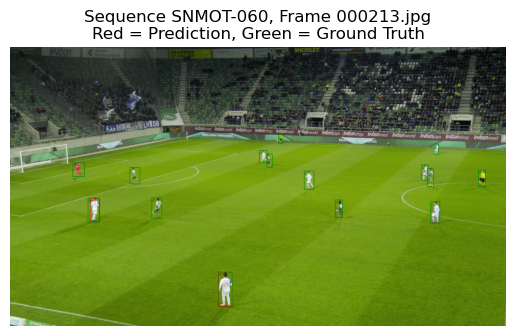

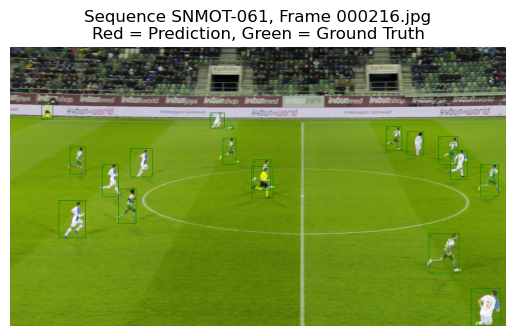

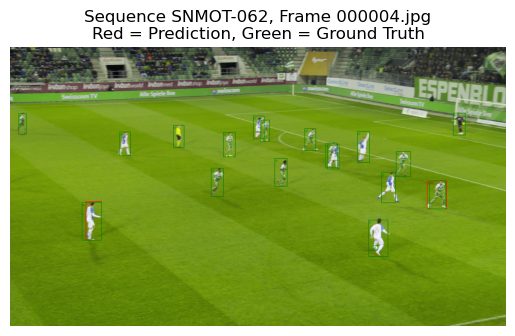

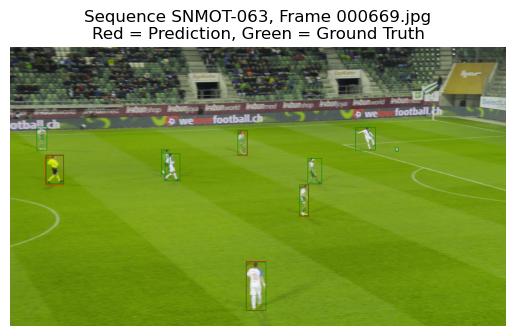

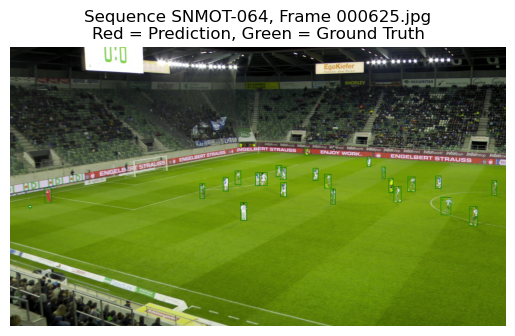

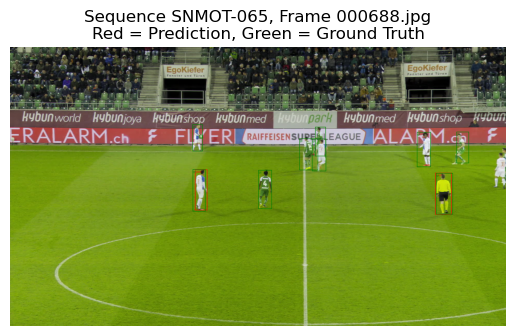

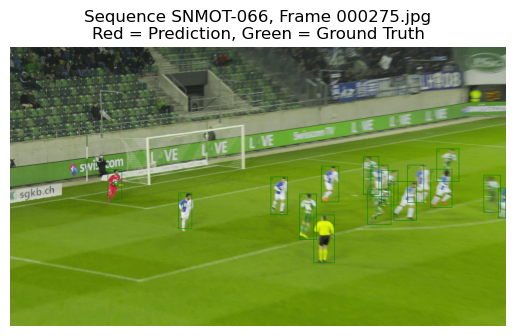

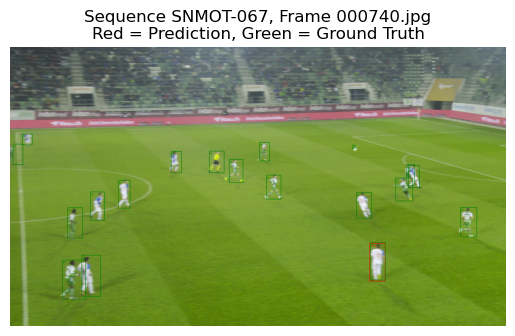

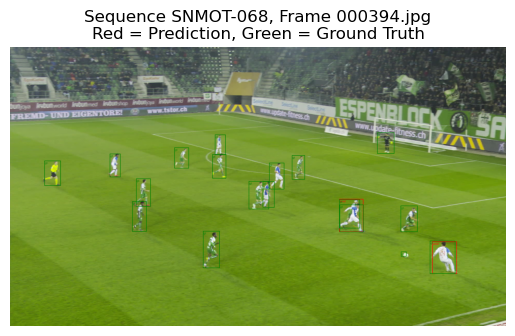

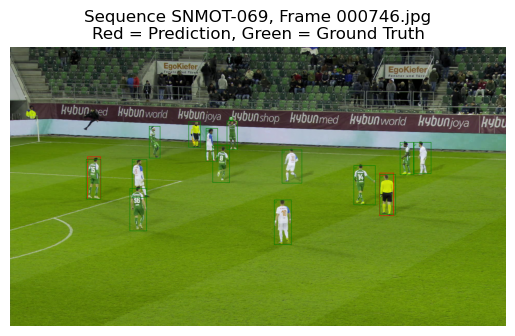

In [9]:


# --- LOAD MODEL ---
model = YOLO("yolo11n.pt")
# model.half().to(DEVICE)
# model.to(DEVICE)

transform = T.ToTensor()

def load_gt_boxes(gt_path):
    gt_dict = defaultdict(list)
    if not os.path.exists(gt_path):
        return gt_dict
    with open(gt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame, _, x, y, w, h, cls, _, _ = map(int, parts[:9])
            gt_dict[frame].append(torch.tensor([x, y, x + w, y + h], device=DEVICE))
    return gt_dict

def compute_iou(box1, box2):
    if box1.size(0) == 0 or box2.size(0) == 0:
        return torch.zeros((box1.size(0), box2.size(0)), device=box1.device)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    lt = torch.max(box1[:, None, :2], box2[:, :2])
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    union = area1[:, None] + area2 - inter
    iou = inter / union
    return iou

def plot_gt_and_detections(image_tensor, detections, gt_boxes):
    from torchvision.utils import draw_bounding_boxes
    all_boxes = []
    labels = []
    colors = []

    for box in detections:
        all_boxes.append(box)
        labels.append("pred")
        colors.append("red")

    for box in gt_boxes:
        all_boxes.append(box)
        labels.append("gt")
        colors.append("green")

    if not all_boxes:
        return T.ToPILImage()(image_tensor)
    
    boxes_tensor = torch.stack(all_boxes).cpu()

    
    x1 = torch.min(boxes_tensor[:, 0], boxes_tensor[:, 2])
    y1 = torch.min(boxes_tensor[:, 1], boxes_tensor[:, 3])
    x2 = torch.max(boxes_tensor[:, 0], boxes_tensor[:, 2])
    y2 = torch.max(boxes_tensor[:, 1], boxes_tensor[:, 3])
    boxes_tensor = torch.stack([x1, y1, x2, y2], dim=1).to(torch.int)
    img_uint8 = (image_tensor * 255).byte().cpu()
    drawn = draw_bounding_boxes(img_uint8, boxes_tensor, labels=labels, colors=colors, width=2)
    return T.ToPILImage()(drawn)

# --- EXECUTION ---
results = []
sample_frames = []
total_tp = total_fp = total_fn = 0

seq_dirs = []
for split in ["train", "test"]:
    split_dir = os.path.join(BASE_DATA_ROOT, split)
    if not os.path.exists(split_dir):
        continue
    for d in sorted(os.listdir(split_dir)):
        full_path = os.path.join(split_dir, d)
        if os.path.isdir(full_path):
            seq_dirs.append((split, d))

print("Using device:", DEVICE)
print("Processing sequences...")

for split, seq_id in tqdm(seq_dirs, desc="Sequences", dynamic_ncols=True):
    seq_path = os.path.join(BASE_DATA_ROOT, split, seq_id)
    img_dir = os.path.join(seq_path, IMAGE_FOLDER)
    gt_path = os.path.join(seq_path, "gt", GT_FILENAME)
    gt_dict = load_gt_boxes(gt_path)

    if not os.path.exists(img_dir):
        continue

    all_img_paths = sorted([
        os.path.join(img_dir, file)
        for file in os.listdir(img_dir)
        if any(file.lower().endswith(ext) for ext in IMAGE_EXTS)
    ])

    random.shuffle(all_img_paths)
    all_img_paths = all_img_paths[:SAMPLE_PER_SEQ]

    for path in all_img_paths:
        try:
            img = Image.open(path).convert("RGB")
        except:
            continue

        img_tensor = transform(img).unsqueeze(0)
        img_tensor = img_tensor.half()
        img_tensor = img_tensor.squeeze(0) 

        img_tensor = img_tensor.to(DEVICE)



        filename = os.path.basename(path)
        try:
            frame_id = int(filename.split('.')[0])
        except:
            continue

        gt_boxes = gt_dict.get(frame_id, [])

        with torch.no_grad():
            yolo_result = model(img)[0]  # Get first result
            preds = yolo_result.boxes.data.to(DEVICE) if yolo_result.boxes is not None else torch.empty((0, 6)).to(DEVICE)

        pred_boxes = preds[:, :4][preds[:, 4] > SCORE_THRESH] if len(preds) else torch.empty((0, 4), device=DEVICE)

        # Accuracy
        if gt_boxes:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            if len(pred_boxes) > 0:
                ious = compute_iou(pred_boxes, gt_tensor)
                max_ious = ious.max(dim=1)[0]
                acc = (max_ious > IOU_THRESH).float().mean().item()
            else:
                acc = 0.0
        else:
            acc = 1.0 if len(pred_boxes) == 0 else 0.0

        results.append(acc)

        # Precision/Recall
        matched_gt = set()
        tp = fp = 0
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            ious = compute_iou(pred_boxes, gt_tensor)
            for i in range(len(pred_boxes)):
                max_iou, gt_idx = ious[i].max(0)
                if max_iou > IOU_THRESH and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1
        else:
            tp = 0
            fp = len(pred_boxes)

        fn = len(gt_boxes) - len(matched_gt)
        total_tp += tp
        total_fp += fp
        total_fn += fn

        if len(sample_frames) < NUM_VISUALS and seq_id not in [s[0] for s in sample_frames]:
            img_vis = plot_gt_and_detections(img_tensor, pred_boxes, gt_boxes)
            sample_frames.append((seq_id, filename, img_vis))
            

# --- METRICS ---
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
avg_acc = sum(results) / len(results) if results else 0
print(f"\nAverage Detection Accuracy over {len(results)} frames: {avg_acc * 100:.2f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}")

# --- SHOW EXAMPLES ---
for seq_id, filename, img in sample_frames:
    plt.imshow(img)
    plt.title(f"Sequence {seq_id}, Frame {filename}\nRed = Prediction, Green = Ground Truth")
    plt.axis("off")
    plt.show()
